In [1]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack

In [2]:
@kwdef struct LIFParameter{FT}
    tref::FT   = 2 # 不応期 (ms)
    tc_m::FT   = 10 # 膜時定数 (ms)
    vrest::FT  = -60 # 静止膜電位 (mV) 
    vreset::FT = -65 # リセット電位 (mV) 
    vthr::FT   = -40 # 閾値電位 (mV)
    vpeak::FT  = 30 #　ピーク電位 (mV)
end

@kwdef mutable struct LIF{FT}
    param::LIFParameter = LIFParameter{FT}()
    N::UInt32 #ニューロンの数
    v::Vector{FT} = fill(-65.0, N) # 膜電位 (mV)
    v_::Vector{FT} = fill(-65.0, N) # 発火電位も記録する変数
    fire::Vector{Bool} = zeros(Bool, N) # 発火
    tlast::Vector{FT} = zeros(N) # 最後の発火時刻 (ms)
    tcount::FT = 0 # 時間カウント
end

In [3]:
function update!(variable::LIF, param::LIFParameter, I::Vector, dt)
    @unpack N, v, v_, fire, tlast, tcount = variable
    @unpack tref, tc_m, vrest, vreset, vthr, vpeak = param
    
    @inbounds for i = 1:N
        #v[i] += dt * ((vrest - v[i] + I[i]) / tc_m) # 不応期を考慮しない場合の更新式
        v[i] += dt * ((dt*tcount) > (tlast[i] + tref))*((vrest - v[i] + I[i]) / tc_m)
        #v[i] += dt * ifelse(dt*tcount[1] > tlast[i] + tref, (vrest - v[i] + I[i]) / tc_m, 0)
    end
    @inbounds for i = 1:N
        fire[i] = v[i] >= vthr
        v_[i] = ifelse(fire[i], vpeak, v[i]) #発火時の電位も含めて記録するための変数 (除いてもよい)
        v[i] = ifelse(fire[i], vreset, v[i])        
        tlast[i] = ifelse(fire[i], dt*tcount, tlast[i]) # 発火時刻の更新
    end
end

update! (generic function with 1 method)

In [4]:
T = 450 # ms
dt = 0.01f0 # ms
nt = UInt32(T/dt) # number of timesteps
N = 1 # ニューロンの数

# 入力刺激
t = Array{Float32}(1:nt)*dt
I = repeat(25f0 * ((t .> 50) - (t .> 200)) + 50f0 * ((t .> 250) - (t .> 400)), 1, N)  # injection current

# 記録用
varr = zeros(Float32, nt, N)

# modelの定義
neurons = LIF{Float32}(N=N)

# simulation
@time for i = 1:nt
    update!(neurons, neurons.param, I[i, :], dt)
    neurons.tcount += 1
    varr[i, :] = neurons.v_
end

  0.120084 seconds (750.74 k allocations: 23.288 MiB, 64.91% compilation time)


In [5]:
using PyPlot

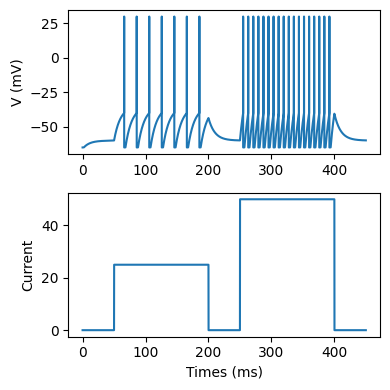

In [6]:
figure(figsize=(4, 4))
subplot(2,1,1); plot(t, varr[:, 1]); ylabel("V (mV)")
subplot(2,1,2); plot(t, I[:, 1]); ylabel("Current");  xlabel("Times (ms)")
tight_layout()

In [7]:
T = 1000 # ms
dt = 0.01f0 # ms
nt = UInt32(T/dt) # number of timesteps
N = 100 # ニューロンの数

# 入力刺激
mincurrent, maxcurrent = 15, 40
t = Array{Float32}(1:nt)*dt
I = Array{Float32}(range(mincurrent,maxcurrent,length=N)) # injection current

# modelの定義
neurons = LIF{Float32}(N=N)

# 記録用
firearr = zeros(Bool, nt, N)

# simulation
@time for i = 1:nt
    update!(neurons, neurons.param, I[:], dt)
    neurons.tcount += 1
    firearr[i, :] = neurons.fire
end

  0.146774 seconds (1.08 M allocations: 67.576 MiB, 5.23% gc time, 23.30% compilation time)


In [8]:
num_spikes = sum(firearr, dims=1)
rate_numeric = num_spikes/T*1e3; 

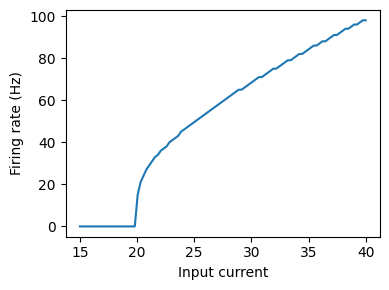

In [9]:
figure(figsize=(4, 3))
plot(I[:], rate_numeric[1, :]); xlabel("Input current"); ylabel("Firing rate (Hz)")
tight_layout()

In [10]:
R = 1.0 #膜抵抗 
tc_m, tref = 10, 2# 膜時定数, 不応期 (ms)
vrest, vthr = -60.0, -40.0 # 静止膜電位, 閾値電位 (mV)
rate_exact = zeros(N)

for i = 1:N
    z = R*I[i] / (R*I[i] + vrest - vthr)
    rate_exact[i] = (z > 0) ? 1 / (tref + tc_m * log(z)) * 1e3 : 0
end 

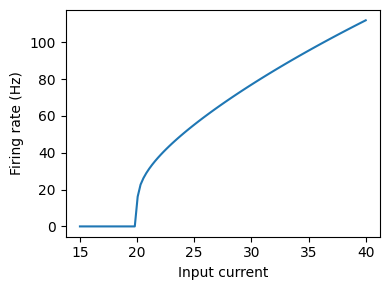

In [11]:
figure(figsize=(4, 3))
plot(I[:], rate_exact[:]); xlabel("Input current"); ylabel("Firing rate (Hz)")
tight_layout()